# Step 8: Feature Selection with Deviance (Pan-Cancer)

This notebook applies deviance-based feature selection on the normalized Pan-Cancer dataset using the `scry` R package. We identify the top 4000 most deviant genes based on their binomial deviance, and annotate them in the AnnData object.


## 8.1 Load Normalized Pan-Cancer Dataset

We load the AnnData file produced after normalization.


In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc

import rpy2.robjects as ro
import rpy2.rinterface_lib.callbacks as rcb
from rpy2.robjects import pandas2ri

# Load dataset
adata = sc.read("../../data/pancancer_normalized_all_layers.h5ad")

# Set up R bridge
rcb.logger.setLevel(logging.ERROR)
pandas2ri.activate()

# Enable %%R cell magic
%load_ext rpy2.ipython


## 8.2 Transfer Raw Counts to R

We extract the raw counts matrix and transfer it to the R environment. R's `scry` package expects a gene-by-cell matrix.


In [2]:
from scipy.sparse import issparse

raw_counts = adata.X.T  # transpose for gene x cell
if issparse(raw_counts):
    raw_counts = raw_counts.toarray()

ro.globalenv["raw_counts"] = raw_counts
ro.globalenv["gene_names"] = adata.var_names.to_list()
ro.globalenv["cell_names"] = adata.obs_names.to_list()


## 8.3 Compute Binomial Deviance in R

Using the `scry::devianceFeatureSelection` function, we calculate gene-level binomial deviance values.


In [3]:
%%R
library(scry)
library(SingleCellExperiment)

sce <- SingleCellExperiment(list(counts = raw_counts))
rownames(sce) <- gene_names
colnames(sce) <- cell_names

sce <- devianceFeatureSelection(sce)
binomial_deviance <- rowData(sce)$binomial_deviance


## 8.4 Select Top 4000 Deviant Genes

We sort the genes by deviance and mark the top 4000 as "highly deviant".


In [4]:
binomial_deviance = np.array(ro.r("binomial_deviance"))
idx = binomial_deviance.argsort()[-4000:]

mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance


## 8.5 Visualize Deviant Genes vs Dispersion

We visualize the selection by comparing deviant genes to standard dispersion-based detection of variable genes.


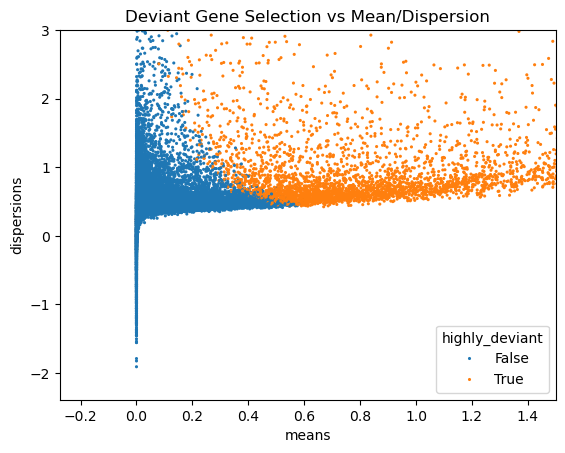

In [5]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

ax = sns.scatterplot(
    data=adata.var,
    x="means", y="dispersions",
    hue="highly_deviant", s=5, linewidth=0
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.title("Deviant Gene Selection vs Mean/Dispersion")
plt.show()


## 8.6 Save Annotated Dataset

Finally, we save the updated AnnData object for use in downstream dimensionality reduction and modeling.


In [6]:
adata.write("../../data/pancancer_feature_selection.h5ad")
print("✅ Saved to 'pancancer_feature_selection.h5ad'")


✅ Saved to 'pancancer_feature_selection.h5ad'
